# Dog Breed classification with cnn

#### Libraries

In [26]:
# plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# tools
import os
from glob import glob
from shutil import copyfile            
from tqdm import tqdm
import random
import time

# numpy
import numpy as np

# sklearn
from sklearn import metrics
from sklearn.datasets import load_files 
from sklearn.metrics import accuracy_score

# keras
import keras
from keras.utils import np_utils

from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img,image
from keras import optimizers

from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications import ResNet50
from keras.applications import resnet50

from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential

from keras.callbacks import ModelCheckpoint, History, EarlyStopping

#### Constants

In [39]:
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 120
INPUT_SHAPE = (256, 256, 3)
IMAGE_SIZE = (256, 256)
SEED = 42

DATA_PATH = '../data/'
DEFAULT_IMG_1 = '../data/test/n02088364-beagle/7.jpg'
DEFAULT_IMG_2 = '../data/test/n02111889-Samoyed/1.jpg'

checkpoint_filepath = '../data/checkpoint'


USE_DROPOUT = True
DROPOUT_RATE = 0.5


## I. Datas

### I.1. Split train test

In [3]:
def img_train_test_split(img_source_dir, train_size, validation_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    * img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    * train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('../data'):
        os.makedirs('../data')
    else:
        if not os.path.exists('../data/train'):
            os.makedirs('../data/train')
        if not os.path.exists('../data/validation'):
            os.makedirs('../data/validation')
        if not os.path.exists('../data/test'):
            os.makedirs('../data/test')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('../data/train', subdir)
        validation_subdir = os.path.join('../data/validation', subdir)
        test_subdir = os.path.join('../data/test', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)
            
        if not os.path.exists(test_subdir):
            os.makedirs(test_subdir)

        train_counter = 0
        validation_counter = 0
        test_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                elif random.uniform(0, 1) <= validation_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                else :
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(test_subdir, str(test_counter) + '.' + fileparts[1]))
                    test_counter += 1

In [5]:
img_train_test_split('../data/images', 0.7, 0.4)

### I.2. Load datasets

In [40]:
def load_dataset(path):
    """
    Load images and label from selected path 
    
    Parameters 
    ----------
    
    path : string
        Path to folder to load
    """
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

In [41]:
train_img, train_targets = load_dataset('../data/train')
val_img, val_targets = load_dataset('../data/validation')
test_img, test_targets = load_dataset('../data/test')

### I.3. Tensors 

In [42]:
def path_to_tensor(img_path):
    '''
    Return a 4D tensor
    
    Parameters
    ----------
    
    img_path : string
        Path to image to transform into tensor
    '''
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) 
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
train_tensors = paths_to_tensor(train_img).astype('float32')/255
val_tensors = paths_to_tensor(val_img).astype('float32')/255
test_tensors = paths_to_tensor(test_img).astype('float32')/255

100%|██████████| 14857/14857 [00:54<00:00, 270.19it/s]


In [6]:
test_tensors = paths_to_tensor(test_img).astype('float32')/255

100%|██████████| 4053/4053 [00:12<00:00, 318.76it/s]


### I.4. Data augmentation

In [43]:
def get_generators(function):
    '''
    Give us the generators for the train, val and test set.
    
    Parameters
    ----------
    function : preprocessing function use for data augmentation
    '''
    
    generators = []
    
    # augmentation configuration for training
    train_datagen = ImageDataGenerator(rotation_range=20,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest',
                                       preprocessing_function=function.preprocess_input)
    
    # generators for train
    train_gen = train_datagen.flow_from_directory('../data/train/',
                                                  target_size = IMAGE_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle=True,
                                                  class_mode = 'categorical',
                                                  seed=SEED)
    #generators for val
    val_gen = train_datagen.flow_from_directory('../data/validation/',
                                                target_size = IMAGE_SIZE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical',
                                                seed=SEED)
    # rescaling
    test_datagen = ImageDataGenerator(preprocessing_function=function.preprocess_input)
    
    #generators for test
    test_gen = train_datagen.flow_from_directory('../data/test/',
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 seed = SEED)
    
    # list of generators
    generators.append(train_gen)
    generators.append(val_gen)
    generators.append(test_gen)
    
    return generators

#### Generators

Vgg16 generators

In [44]:
vgg16_train_gen, vgg16_val_gen, vgg16_test_gen = get_generators(vgg16)

Found 14857 images belonging to 120 classes.
Found 2761 images belonging to 120 classes.
Found 4053 images belonging to 120 classes.


ResNet generators

In [8]:
resnet_train_gen, resnet_val_gen, resnet_test_gen = get_generators(resnet50)

Found 14857 images belonging to 120 classes.
Found 2761 images belonging to 120 classes.
Found 4053 images belonging to 120 classes.


## II. Models

### II.1. Compile

In [45]:
def model(model):
    """
    Compile a cnn model
    
    """
    pretrained_model= model(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
    
    for layer in pretrained_model.layers:
        layer.trainable = False
        
    x = pretrained_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(DROPOUT_RATE)(x)
    predictions = Dense(120, activation='softmax')(x)

    model = Model(inputs = pretrained_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Vgg16

In [46]:
vgg16_model = model(VGG16)

In [89]:
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

Resnet50 

In [10]:
resnet_model = model(ResNet50)

/home/bayet/.virtualenvs/py3cv4/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### II.2. Train model

#### Callbacks 

In [47]:
class TimeHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time()-self.epoch_time_start)

In [48]:
def get_callbacks(model_name):
    """
    Return callbacks : checkpoint, time and early stopping
    """
    save_callback = ModelCheckpoint( filepath=checkpoint_filepath, 
                                    monitor='val_accuracy',
                                    verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto',
                                    period=2)
    time_callback = TimeHistory()
    early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=2)
    
    return [save_callback, time_callback, early_stop_callback]

##### Vgg16 callbacks 

In [49]:
vgg16_callbacks = get_callbacks(vgg16)

##### Resnet callbacks 

In [28]:
resnet_callbacks = get_callbacks(resnet50)

#### Train model

In [50]:
def train_model(model, callbacks, generator, val_generator):
    """
    Train model with generators
    """
    history = model.fit_generator(generator=generator,
                                  validation_data=val_generator,
                                  epochs=EPOCHS,
                                  steps_per_epoch= len(generator.classes) // BATCH_SIZE,
                                  validation_steps= len(generator.classes) // BATCH_SIZE,
                                  workers=4,
                                  callbacks = callbacks)
    
    return model, history

In [52]:
vgg16 = train_model(vgg16_model, vgg16_callbacks, vgg16_train_gen, vgg16_val_gen )

Epoch 1/10
928/928 [==============================] - 10376s 11s/step - loss: 2.7377 - accuracy: 0.3279 - val_loss: 1.1851 - val_accuracy: 0.5749
Epoch 2/10
928/928 [==============================] - 8236s 9s/step - loss: 1.8972 - accuracy: 0.4797 - val_loss: 0.9483 - val_accuracy: 0.6326

Epoch 00002: val_accuracy improved from -inf to 0.63255, saving model to ../data/checkpoint
Epoch 3/10
928/928 [==============================] - 7929s 9s/step - loss: 1.7279 - accuracy: 0.5172 - val_loss: 1.1963 - val_accuracy: 0.6494
Epoch 4/10
928/928 [==============================] - 7922s 9s/step - loss: 1.6650 - accuracy: 0.5353 - val_loss: 1.8091 - val_accuracy: 0.6355

Epoch 00004: val_accuracy improved from 0.63255 to 0.63546, saving model to ../data/checkpoint
Epoch 5/10
928/928 [==============================] - 7908s 9s/step - loss: 1.6145 - accuracy: 0.5483 - val_loss: 0.8330 - val_accuracy: 0.6527
Epoch 6/10
928/928 [==============================] - 7944s 9s/step - loss: 1.5554 - accu

In [29]:
resnet = train_model(resnet_model, resnet_callbacks, resnet_train_gen, resnet_val_gen )

Epoch 1/10
928/928 [==============================] - 5738s 6s/step - loss: 1.2411 - accuracy: 0.6362 - val_loss: 1.5271 - val_accuracy: 0.7390
Epoch 2/10
928/928 [==============================] - 5778s 6s/step - loss: 1.2719 - accuracy: 0.6361 - val_loss: 0.4254 - val_accuracy: 0.7326

Epoch 00002: val_accuracy improved from -inf to 0.73260, saving model to ../data/checkpoint
Epoch 3/10
928/928 [==============================] - 5748s 6s/step - loss: 1.2560 - accuracy: 0.6357 - val_loss: 0.8483 - val_accuracy: 0.7454
Epoch 4/10
928/928 [==============================] - 5768s 6s/step - loss: 1.2594 - accuracy: 0.6339 - val_loss: 0.6316 - val_accuracy: 0.7328

Epoch 00004: val_accuracy improved from 0.73260 to 0.73280, saving model to ../data/checkpoint
Epoch 5/10
928/928 [==============================] - 5738s 6s/step - loss: 1.2218 - accuracy: 0.6398 - val_loss: 1.0237 - val_accuracy: 0.7348


In [36]:
resnet_model.load_weights(checkpoint_filepath)

# III. Evaluation of models 

### II.1. Accuracy

In [69]:
def stats(model_stats, model_name, history, test_accuracy):
    model_stats['models'].append(model_name)

    #Accuracy & validation accuracy
    acc = history.history['accuracy'][-1]
    model_stats['accuracy'].append(acc * 100)
    model_stats['test_accuracy'].append(test_accuracy * 100)

    #Mean epoch training time
    #epoch_training_time = np.mean(time_callback.times[1:])
    #model_stats['epoch_training_time'].append(epoch_training_time)

    #Inference time
    #model_stats['inference_time_10000pic'].append(inference_time * 10000)

    #Print results
    print('Accuracy: %0.1f%% / Test accuracy: %0.1f%%' %(acc*100, test_accuracy*100))
    #print('Mean epoch training time: %is' %int(epoch_training_time))
    #print('Mean 10000 inference time: %0.1fs' %(inference_time*10000))

    return model_stats

In [67]:
model_stats = {'models': [],
               'accuracy': [],
               'test_accuracy': []}

In [59]:
def plot_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    t = np.linspace(1, len(acc), len(acc)).flatten()
    plt.plot(t, acc, 'navy', label='train accuracy')
    plt.plot(t, val_acc, 'lightblue', label='validation accuracy')

    plt.grid(True)
    plt.xlabel('Epochs')
    plt.title('Validation accuracy')
    plt.legend(loc=4)
    plt.show();

#### Vgg16

In [55]:
vgg16_model = vgg16[0]
vgg16_history = vgg16[1]

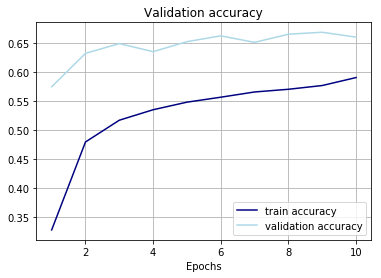

In [60]:
plot_acc(vgg16_history)

In [62]:
vgg16_test_accuracy = vgg16_model.evaluate_generator(vgg16_test_gen, 
                                                     steps= len(vgg16_test_gen.classes) // BATCH_SIZE)[1]

NameError: name 'model_stats' is not defined

In [71]:
stats(model_stats, 'VGG16', vgg16_history, vgg16_test_accuracy)

Accuracy: 59.1% / Test accuracy: 65.5%


{'accuracy': [59.079575538635254],
 'models': ['VGG16'],
 'test_accuracy': [65.51383137702942]}

#### Resnet

In [ ]:
resnet_model = resnet[0]
resnet_history = resnet[1]

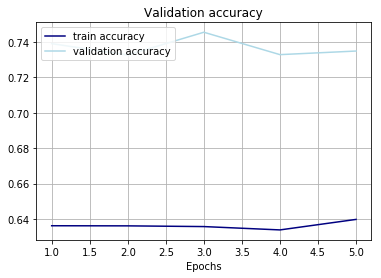

In [36]:
plot_acc(resnet_history)

In [41]:
resnet_test_accuracy = resnet_model.evaluate_generator(resnet_test_gen, 
                                                       steps= len(resnet_test_gen.classes) // BATCH_SIZE)[1]

model_stats(model_stats, 'Resnet50', resnet_history, resnet_test_accuracy)

In [63]:
model_stats

NameError: name 'model_stats' is not defined

### II.3. Model prediction 

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, plot_values=False, printed=False,
                          title='Confusion matrix',
                          figsize=(20,20), cmap=plt.cm.Blues, rotation_xticks=90):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if printed:
        print(cm)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=rotation_xticks)
    plt.yticks(tick_marks, classes)

    if plot_values:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            val = format(cm[i, j], fmt)
            val = int(float(val)) if (float(val) >= 1.) else val
            if float(val):
                plt.text(j, i, val,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [74]:
gen_iter = len(vgg16_test_gen.classes) // BATCH_SIZE

y_pred = vgg16_model.predict_generator(vgg16_test_gen, gen_iter)
y_pred = np.argmax(y_pred, axis=1)

y_true = vgg16_test_gen.classes
y_true = y_true[:y_pred.shape[0]]

In [83]:
def get_dog_breeds(generator):
    dog_breeds = generator.class_indices
    dog_breeds = [k for k in dog_breeds.keys()]
    dog_breeds.sort()

   # with open(DATA_PATH + 'breed_list.pickle', 'wb') as fp:
       # pickle.dump(dog_breeds, fp)

    return dog_breeds

Normalized confusion matrix


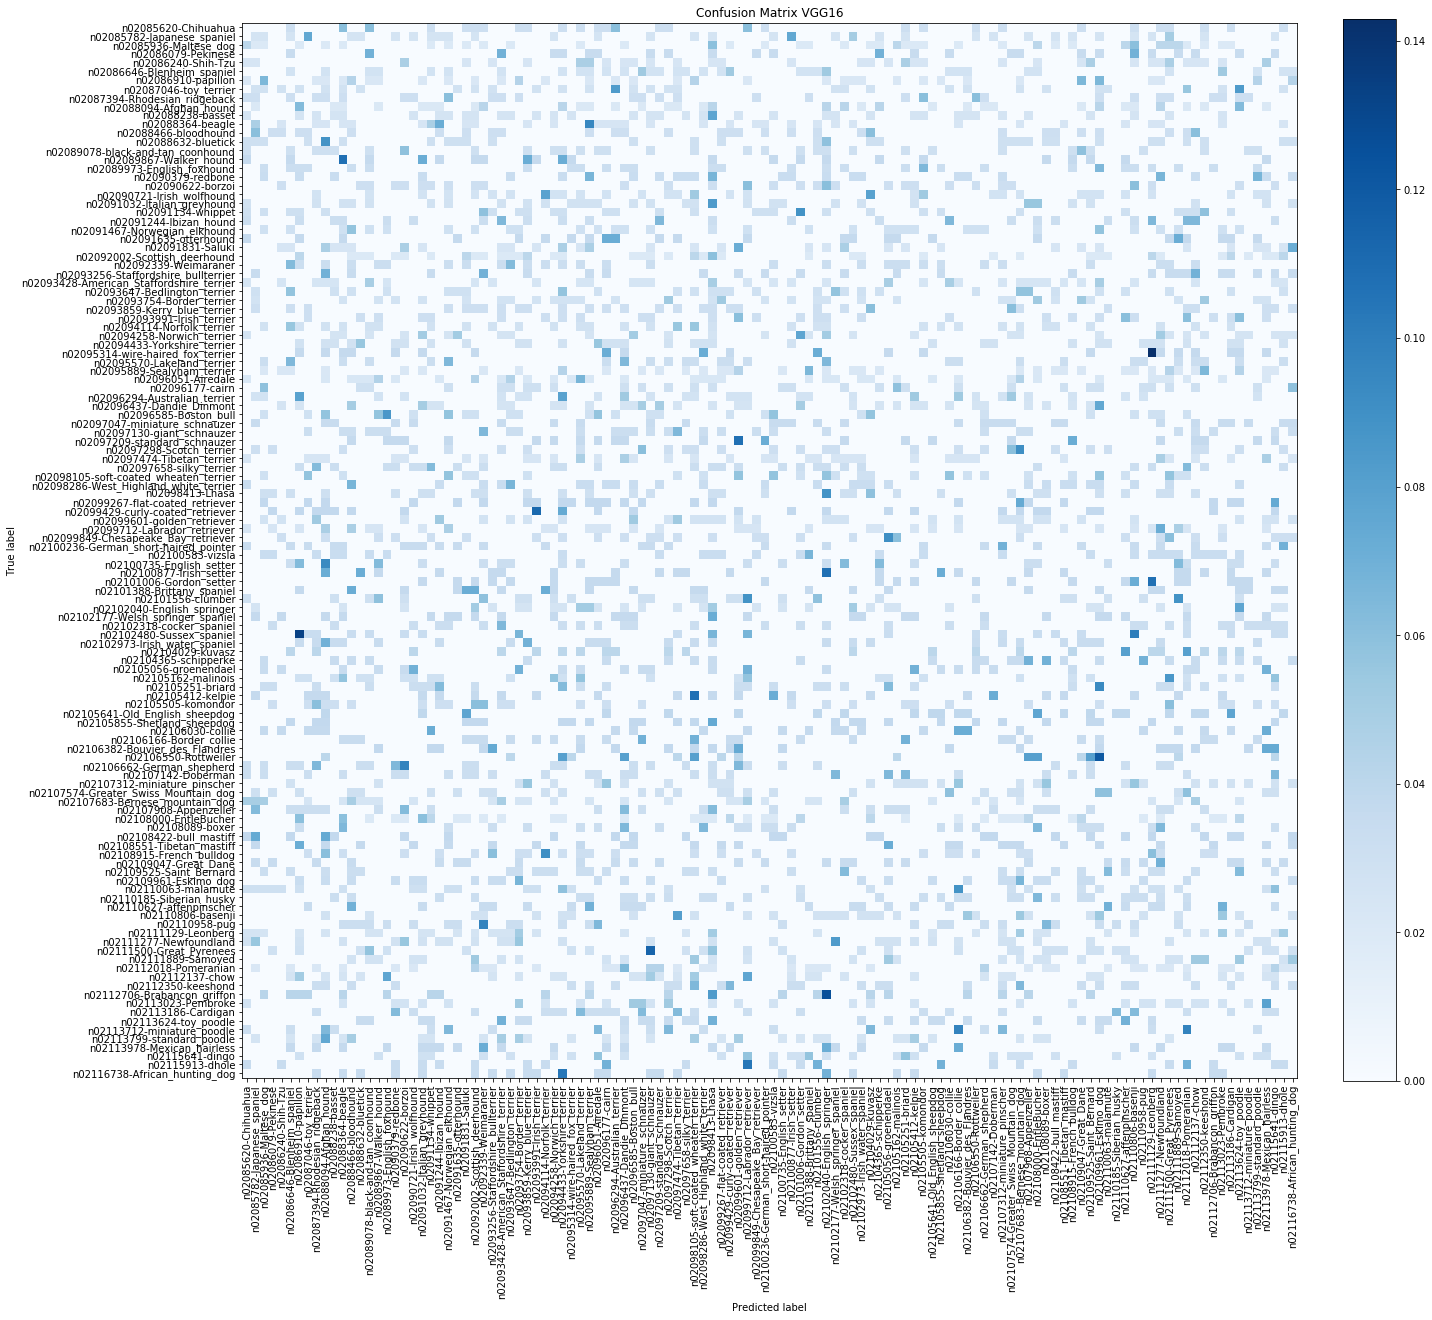

In [87]:
conf_mat = metrics.confusion_matrix(y_true, y_pred)
dog_breeds = get_dog_breeds(vgg16_test_gen)
plot_confusion_matrix(conf_mat, dog_breeds, normalize=True, title='Confusion Matrix VGG16')

In [53]:
dog_names = [item[23:-1] for item in sorted(glob("../data/test/*/"))]

def final_predict(img_path, topk = 3):
    
    # obtain predicted vector
    
    predicted_vector = resnet_model.predict(preprocess_input(path_to_tensor(img_path)))
    
    # return dog breed that is predicted by the model
    # print(dog_names[np.argmax(predicted_vector)])
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    classes = [dog_names[x] for x in classes_ind][:topk]
    probs = [x[1] for x in results][:topk]
    
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    img = mpimg.imread(img_path)
    ax1.imshow(img)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ind = np.arange(len(classes))
    ax2.bar(ind, probs, align='center', alpha = .75)
    ax2.set_xticks(ind)
    ax2.set_xticklabels(classes, rotation=90)

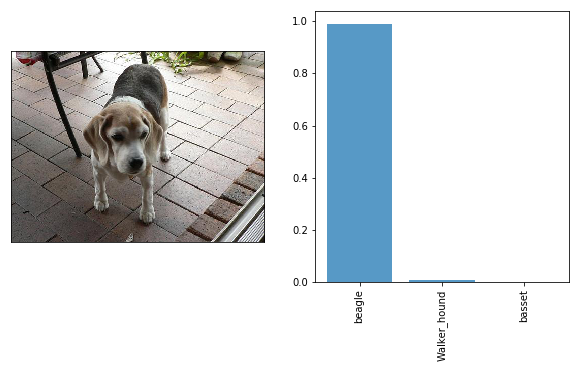

In [54]:
final_predict(DEFAULT_IMG_1)

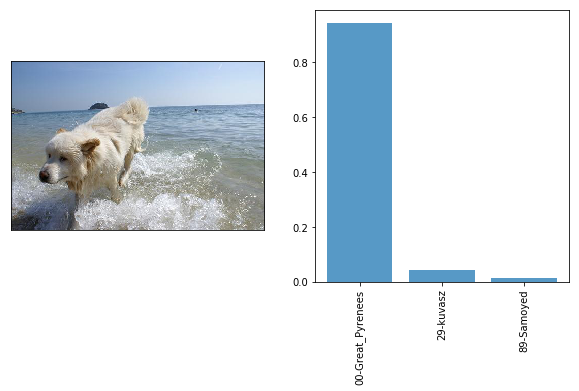

In [35]:
final_predict(DEFAULT_IMG_2)